In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import random
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
# Direktori dataset
base_dir = 'dataset/split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


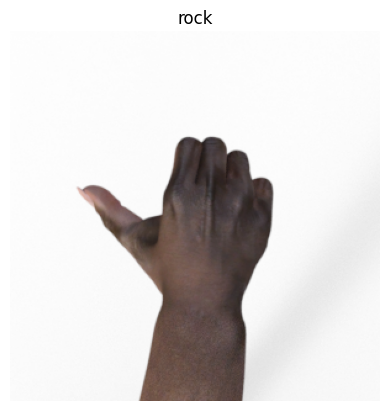

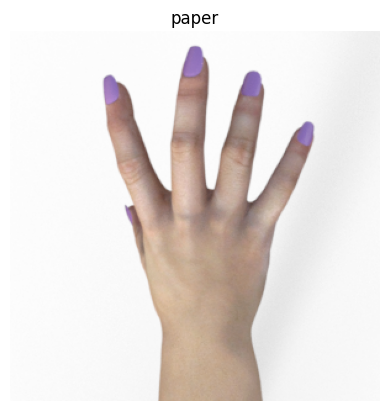

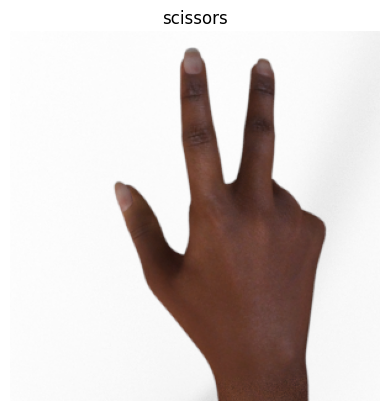

In [5]:
classes = ['rock', 'paper', 'scissors']
for cls in classes:
    class_dir = os.path.join(train_dir, cls)
    image_files = os.listdir(class_dir)
    
    # Pilih satu gambar secara acak
    random_image = random.choice(image_files)
    
    # Baca dan tampilkan gambar
    img_path = os.path.join(class_dir, random_image)
    img = mpimg.imread(img_path)
    
    # Tampilkan gambar
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
    plt.show()

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 150),
    batch_size=32,
    class_mode='categorical'
)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(100, 150),
    batch_size=32,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(100, 150),
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

Found 2284 images belonging to 3 classes.
Found 1090 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [7]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(100, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [8]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.000003
)

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Melatih model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction]
)

Epoch 1/10
72/72 [==============================] - 13s 173ms/step - loss: 1.1208 - accuracy: 0.3980 - val_loss: 1.0536 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 2/10
72/72 [==============================] - 13s 174ms/step - loss: 0.9212 - accuracy: 0.5687 - val_loss: 0.5295 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 3/10
72/72 [==============================] - 13s 176ms/step - loss: 0.3831 - accuracy: 0.8730 - val_loss: 0.1013 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 4/10
72/72 [==============================] - 12s 172ms/step - loss: 0.2043 - accuracy: 0.9378 - val_loss: 0.0691 - val_accuracy: 0.9826 - lr: 0.0010
Epoch 5/10
72/72 [==============================] - 12s 172ms/step - loss: 0.1149 - accuracy: 0.9650 - val_loss: 0.0297 - val_accuracy: 0.9927 - lr: 0.0010
Epoch 6/10
72/72 [==============================] - 12s 169ms/step - loss: 0.0890 - accuracy: 0.9742 - val_loss: 0.0170 - val_accuracy: 0.9972 - lr: 0.0010
Epoch 7/10
72/72 [==============================] - 12s 166ms/st

In [10]:
num_test_samples = len(test_generator.filenames)
Y_pred = model.predict_generator(test_generator, num_test_samples)
y_pred = np.argmax(Y_pred, axis=1)

/var/folders/kf/kz6s4skj1fz2hztzpjm6v4_00000gn/T/ipykernel_70250/766898900.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, num_test_samples)


In [11]:
target_names = ['Rock', 'Paper', 'Scissors']
print('\nClassification Report\n')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Tampilkan grafik akurasi dan loss
plt.figure(figsize=(14, 5))


Classification Report

              precision    recall  f1-score   support

        Rock       1.00      1.00      1.00        82
       Paper       1.00      1.00      1.00        82
    Scissors       1.00      1.00      1.00        79

    accuracy                           1.00       243
   macro avg       1.00      1.00      1.00       243
weighted avg       1.00      1.00      1.00       243



<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

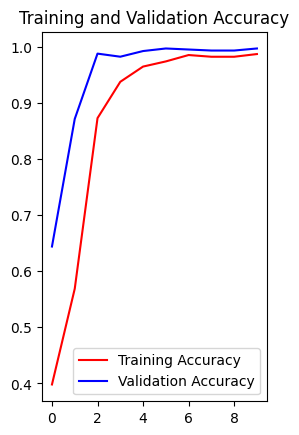

In [12]:
# Grafik Akurasi
plt.subplot(1, 2, 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
acc_plot, = plt.plot(epochs, acc, 'r')
val_acc_plot, = plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


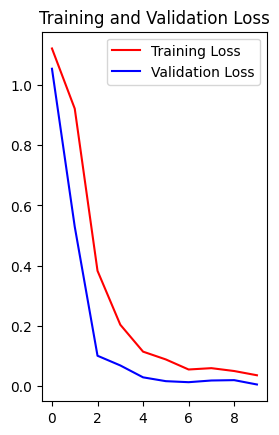

In [13]:
# Grafik Loss
plt.subplot(1, 2, 2)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
loss_plot, = plt.plot(epochs, loss, 'r')
val_loss_plot, = plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

plt.show()

In [14]:
def get_class(file_name):
  return file_name.split('/')[3].split('\\')[0]

1/1 [==============================] - 0s 10ms/step


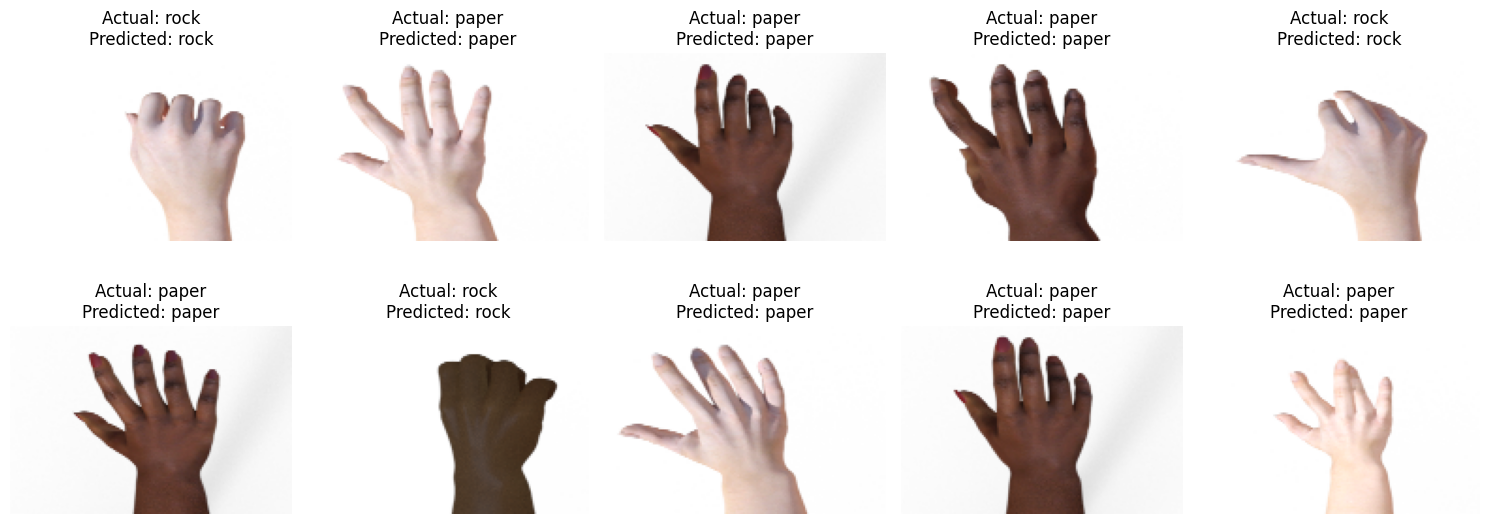

In [15]:
import random
import cv2

random_numbers = [random.randint(0, 126 - 1) for _ in range(10)]
class_labels = list(test_generator.class_indices.keys())

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    img_path = test_generator.filepaths[random_numbers[i]]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 100))  # Resize to (100, 150) to match the model input shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    prediction = model.predict(img.reshape(1, 100, 150, 3))  # Ensure the correct input shape
    predicted_label = class_labels[np.argmax(prediction)]
    
    actual_label = get_class(img_path)
    
    ax.imshow(img)
    ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
model.save('rock_paper_scissors_model.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
